/tmp/ipykernel_3394/1122108215.py:36: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gag_time_over_issue_date_df__year = gag_time_over_issue_date_df.groupby(gag_time_over_issue_date_df.nsl_issue_dates.dt.year).mean()


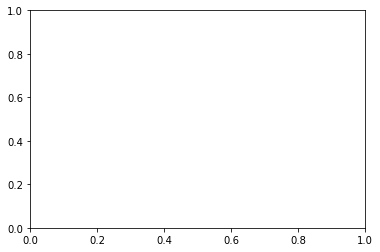

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt

EXTRACTED_DATA_PATH = "../../data/extracted"
OUTPUT_DATA_DIR = "../../data/processed"

colors = plt.cm.get_cmap('hsv', 50)

# Read data
csv_google = pd.read_csv(f'{EXTRACTED_DATA_PATH}/nsl_letters_google.csv')
csv_apple = pd.read_csv(f'{EXTRACTED_DATA_PATH}/nsl_letters_apple.csv')
csv_nslarchive = pd.read_csv(f'{EXTRACTED_DATA_PATH}/nsl_letters_nslarchive.csv')
csv = pd.concat([csv_google, csv_apple, csv_nslarchive])

# earlier date when the letter is served
csv['nsl_issue_dates'] = nsl_issue_dates = [datetime.strptime(val, "%Y-%m-%d") for val in csv['issue date'].values]

# later date when the letter is published
csv['nsl_release_dates'] = nsl_release_dates = [datetime.strptime(val, "%Y-%m-%d") for val in csv['release date'].values]

# proxy for gag order time: difference between issue and release dates
gag_time = [(nsl_release_dates[i] - nsl_issue_dates[i]).days for i in range(len(nsl_release_dates))]

# Sort nsls by issue dates
nsl_issue_dates_zip_gag_time = zip(nsl_issue_dates, gag_time)
nsl_issue_dates_zip_gag_time_s = sorted(nsl_issue_dates_zip_gag_time, key=lambda x: x[0])
nsl_issue_dates_s, gag_time_s = zip(*nsl_issue_dates_zip_gag_time_s)
gag_time_s = [float(ss) for ss in gag_time_s]

# Create pandas frame for the inferred gag time over issue dates 
gag_time_over_issue_date_df = pd.DataFrame({'nsl_issue_dates' : nsl_issue_dates_s, 'gag_time' : gag_time_s}, columns=['nsl_issue_dates', 'gag_time'])

# Aggregate the data per year, compute the mean, minimum, and maximum for every year
gag_time_over_issue_date_df__year = gag_time_over_issue_date_df.groupby(gag_time_over_issue_date_df.nsl_issue_dates.dt.year).mean()
gag_time_over_issue_date_df__year_min = gag_time_over_issue_date_df.groupby(gag_time_over_issue_date_df.nsl_issue_dates.dt.year).min()
gag_time_over_issue_date_df__year_max = gag_time_over_issue_date_df.groupby(gag_time_over_issue_date_df.nsl_issue_dates.dt.year).max()

# Plot the gag order time
plt.rc("axes", axisbelow=True)
plt.rcParams["font.size"] = 24
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,8)
plt.ticklabel_format(style='plain')

colors_wong = [
    "#000000", "#e69f00", "#56b4e9", "#009e73",
    "#f0e442", "#0072b2", "#d55e00", "#cc79a7"
]

Use degree 20 polyfit


/tmp/ipykernel_26655/3127973171.py:71: RankWarning: Polyfit may be poorly conditioned
  trend_issue_date, trend_release_date = poly_regression(nsl_issue_dates_trend, nsl_release_dates_trend, deg=20)


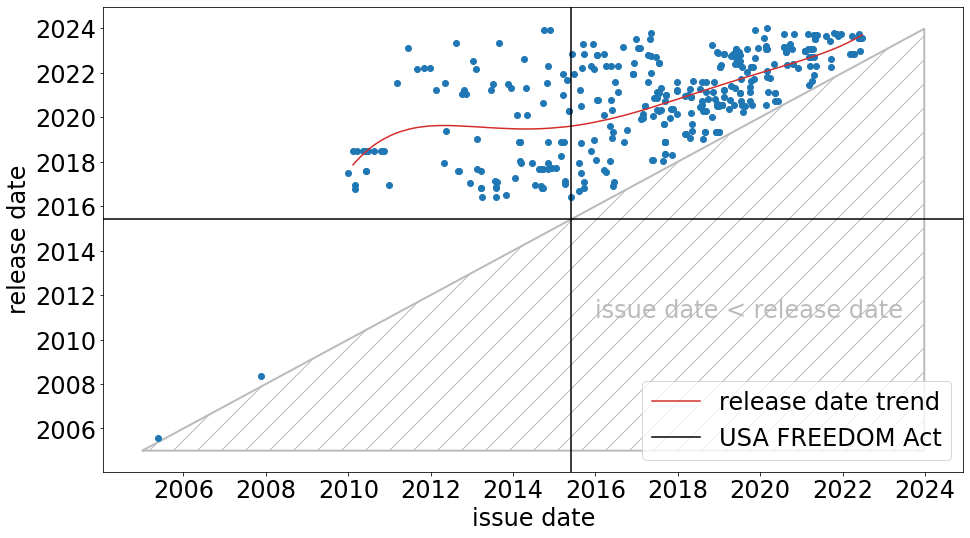

In [4]:
import numpy as np
from copy import deepcopy

plt.rc("axes", axisbelow=False)
plt.rcParams["font.size"] = 24
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,8)

# diagonal to show dead triangle
nsl_release_dates_min = datetime(year=2005, month=1, day=1)
nsl_release_dates_max = datetime(year=2024, month=1, day=1)
x_values = np.arange(nsl_release_dates_min, nsl_release_dates_max, (nsl_release_dates_max - nsl_release_dates_min)/1000)
bottom_line = [nsl_release_dates_min] * len(x_values)
# plt.plot(x_values, x_values, color="#d52d2a")

plt.fill_between(x_values, bottom_line, x_values, edgecolor="#bbbbbb", facecolor="none", linewidth=2, hatch="/")
mid = nsl_release_dates_min + (nsl_release_dates_max - nsl_release_dates_min)/4
plt.text(datetime(year=2016, month=1, day=1), datetime(year=2011, month=1, day=1), "issue date < release date", color="#bbbbbb")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_triangle.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_triangle.png")

# scatter plot with dots for every release/issue date
plt.scatter(nsl_issue_dates, nsl_release_dates)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_scatter_points.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_scatter_points.png")

# Trend line
def to_ordinal(xs):
    return list(map(lambda x: x.toordinal(), xs))

def from_ordinal(xs):
    return list(map(lambda x: datetime.fromordinal(int(x)), xs))

def poly_regression(xs_ts, ys_ts, deg=1):
    """
    Compute regression on xs, ys with polynomial of degree `deg`
    (for deg=1, this computes the linear regression)
    """                               

    xs_ordinal = to_ordinal(xs_ts)
    ys_ordinal = to_ordinal(ys_ts)

    print(f"Use degree {deg} polyfit")
    x_vals = np.array(xs_ordinal)
    coeffs = np.polyfit(xs_ordinal, np.array(ys_ordinal), deg=deg)
    new_xs_ordinal = np.linspace(min(xs_ordinal), max(xs_ordinal), len(x_vals))
    new_ys_ordinal = []
    for x in new_xs_ordinal:
        y = 0
        for i, coeff in enumerate(coeffs):
            y += x**(deg-i) * coeff
        new_ys_ordinal.append(y)

    new_xs_ordinal = from_ordinal(new_xs_ordinal)
    new_ys_ordinal = from_ordinal(new_ys_ordinal)

    return new_xs_ordinal, new_ys_ordinal

# Remove early outliers before plotting trend
nsl_issue_dates_trend = []
nsl_release_dates_trend = []
for i, issue_date in enumerate(nsl_issue_dates):
    if issue_date.year >= 2010:
        nsl_issue_dates_trend.append(issue_date)
        nsl_release_dates_trend.append(nsl_release_dates[i])

trend_issue_date, trend_release_date = poly_regression(nsl_issue_dates_trend, nsl_release_dates_trend, deg=20)
plt.plot(trend_issue_date, trend_release_date, color="#d52d2a", label="release date trend")

plt.tight_layout()
plt.legend()
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_trend.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_trend.png")

# Add FREEDOM Act line
plt.axhline(y=datetime(year=2015, month=6, day=2), color=colors_wong[0], linestyle='-', label="USA FREEDOM Act")
plt.axvline(x=datetime(year=2015, month=6, day=2), color=colors_wong[0], linestyle='-')

plt.xlabel("issue date")
plt.ylabel("release date")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot.png")

Use degree 10 polyfit


/tmp/ipykernel_3394/729336564.py:91: RankWarning: Polyfit may be poorly conditioned
  trend_issue_date, trend_release_date = poly_regression(nsl_issue_dates_trend, gag_time_in_years_trend, deg=10)


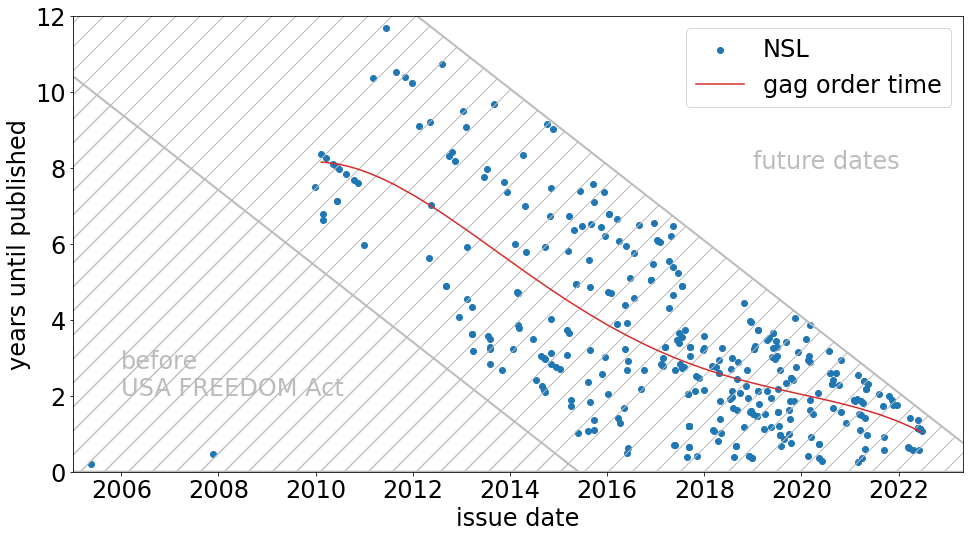

In [5]:
import numpy as np

plt.rc("axes", axisbelow=False)
plt.rcParams["font.size"] = 24
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,8)

plt.xlabel("issue date")
plt.ylabel("years until published")

def to_ordinal(xs):
    return list(map(lambda x: x.toordinal(), xs))

def from_ordinal(xs):
    return list(map(lambda x: datetime.fromordinal(int(x)), xs))

gag_time_in_years = [t / 365 for t in gag_time]

issue_date_min = datetime(year=2005, month=1, day=1)

# scatter plot with dots for every release/issue date
plt.scatter(nsl_issue_dates, gag_time_in_years, label="NSL")

plt.xlim(issue_date_min)
plt.ylim(0, 12)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/gag_order_time_until_published_dots.png")

# Add FREEDOM Act triangle to show which NSLs were published after the FREEDOM act
freedom_act_date = datetime(year=2015, month=6, day=2)
def freedom_line(x):
    return (freedom_act_date - x).days / 365

freedom_act_issue_dates = from_ordinal(np.linspace(issue_date_min.toordinal(), freedom_act_date.toordinal(), 1000))
freedom_act_y_axis_data_point = [freedom_line(issue_date) for issue_date in freedom_act_issue_dates]
# plt.plot(freedom_act_issue_dates, freedom_act_y_axis_data_point, color=colors_wong[0], linestyle='-', label="USA FREEDOM Act")

bottom_line = [0] * len(freedom_act_issue_dates)
plt.fill_between(freedom_act_issue_dates, bottom_line, freedom_act_y_axis_data_point, edgecolor="#bbbbbb", facecolor="none", linewidth=2, hatch="/")
plt.text(datetime(year=2006, month=1, day=1), 2, "before\nUSA FREEDOM Act", color="#bbbbbb")

# Add future triangle to show which dates are in the future
last_analyzed_date = datetime(year=2024, month=2, day=1)
def future_line(x):
    return (last_analyzed_date - x).days / 365

future_issue_dates = from_ordinal(np.linspace(issue_date_min.toordinal(), last_analyzed_date.toordinal(), 1000))
future_y_axis_data_point = [future_line(issue_date) for issue_date in future_issue_dates]

top_line = [12] * len(future_issue_dates)
plt.fill_between(future_issue_dates, top_line, future_y_axis_data_point, edgecolor="#bbbbbb", facecolor="none", linewidth=2, hatch="/")
plt.text(datetime(year=2019, month=1, day=1), 8, "future dates", color="#bbbbbb")

plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/gag_order_time_until_published_freedom.png")

# Trend line
def poly_regression(xs_ts, ys, deg=1):
    """
    Compute regression on xs, ys with polynomial of degree `deg`
    (for deg=1, this computes the linear regression)
    """                               

    xs_ordinal = to_ordinal(xs_ts)

    print(f"Use degree {deg} polyfit")
    x_vals = np.array(xs_ordinal)
    coeffs = np.polyfit(xs_ordinal, np.array(ys), deg=deg)
    new_xs_ordinal = np.linspace(min(xs_ordinal), max(xs_ordinal), len(x_vals))
    new_ys = []
    for x in new_xs_ordinal:
        y = 0
        for i, coeff in enumerate(coeffs):
            y += x**(deg-i) * coeff
        new_ys.append(y)

    new_xs_ordinal = from_ordinal(new_xs_ordinal)

    return new_xs_ordinal, new_ys

# Remove early outliers before plotting trend
nsl_issue_dates_trend = []
gag_time_in_years_trend = []
for i, issue_date in enumerate(nsl_issue_dates):
    if issue_date.year >= 2010:
        nsl_issue_dates_trend.append(issue_date)
        gag_time_in_years_trend.append(gag_time_in_years[i])

trend_issue_date, trend_release_date = poly_regression(nsl_issue_dates_trend, gag_time_in_years_trend, deg=10)
plt.plot(trend_issue_date, trend_release_date, color="#d52d2a", label="gag order time")

plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/gag_order_time_until_published.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/gag_order_time_until_published.png")
plt.savefig(f"{OUTPUT_DATA_DIR}/gag_order_time_until_published.jpg")

/tmp/ipykernel_17239/3953741625.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar([datetime(v, 6, 1) for v in gag_time_over_issue_date_df__year.index.values], gag_time_over_issue_date_df__year['gag_time'].values.tolist(),


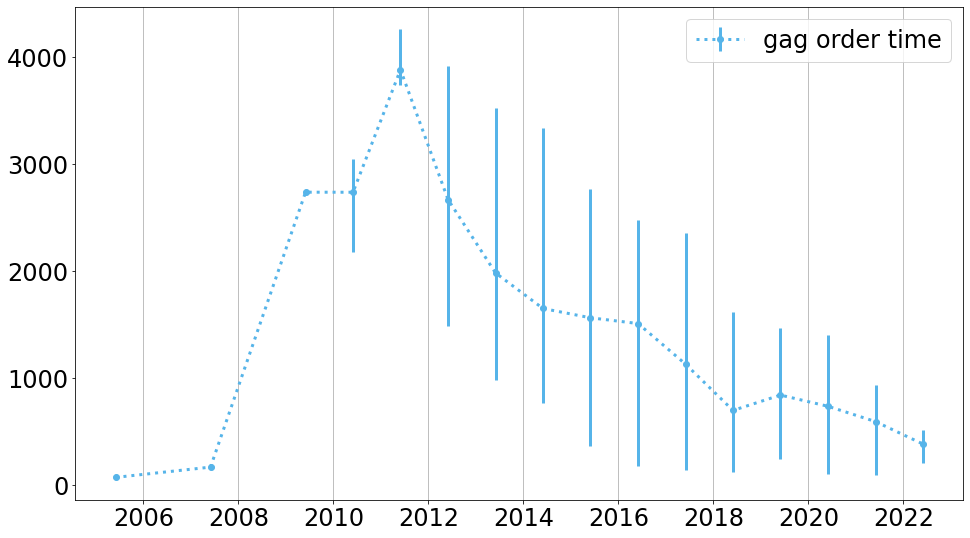

In [17]:
# Paper plot

plt.errorbar([datetime(v, 6, 1) for v in gag_time_over_issue_date_df__year.index.values], gag_time_over_issue_date_df__year['gag_time'].values.tolist(),
   yerr =  (np.array(gag_time_over_issue_date_df__year['gag_time' ].values.tolist()) - np.array(gag_time_over_issue_date_df__year_min['gag_time'].values.tolist()),
            np.array(gag_time_over_issue_date_df__year_max['gag_time' ].values.tolist()) - np.array(gag_time_over_issue_date_df__year['gag_time'].values.tolist())),
   linestyle='dotted', marker='o', label="gag order time", color="#56b4e9", fmt='o', elinewidth=3, linewidth=3)

plt.grid(True, which="major")
plt.grid(True, which="minor")
plt.grid(axis="y")
plt.legend()                                                                                                                                                                        
plt.xlabel(None)
plt.ylabel(None)
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/mean_gag_time_over_time_yearly_date_let__errorbar.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/mean_gag_time_over_time_yearly_date_let__errorbar.png")

/tmp/ipykernel_17239/3580830265.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar([datetime(v, 6, 1) for v in gag_time_over_issue_date_df__year.index.values], gag_time_over_issue_date_df__year['gag_time'].values.tolist(),


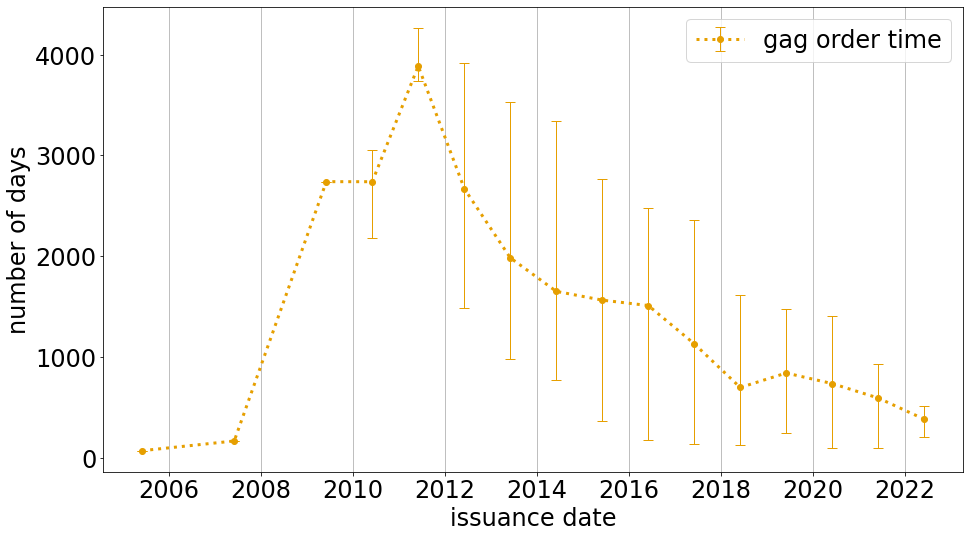

In [18]:
# Presentation plot

# Plot the gag order time
plt.rc("axes", axisbelow=True)
plt.rcParams["font.size"] = 24
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,8)
plt.ticklabel_format(style='plain')

plt.errorbar([datetime(v, 6, 1) for v in gag_time_over_issue_date_df__year.index.values], gag_time_over_issue_date_df__year['gag_time'].values.tolist(),
   yerr =  (np.array(gag_time_over_issue_date_df__year['gag_time' ].values.tolist()) - np.array(gag_time_over_issue_date_df__year_min['gag_time'].values.tolist()),
            np.array(gag_time_over_issue_date_df__year_max['gag_time' ].values.tolist()) - np.array(gag_time_over_issue_date_df__year['gag_time'].values.tolist())),
   linestyle='dotted', marker='o', label="gag order time", color="#e69f00", fmt='o', elinewidth=1, linewidth=3, capsize=5)

plt.grid(True, which="major")
plt.grid(True, which="minor")
plt.grid(axis="y")
plt.xlabel("issuance date")
plt.ylabel("number of days")
plt.legend()    
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/mean_gag_time_over_time_yearly_date_let__errorbar.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/mean_gag_time_over_time_yearly_date_let__errorbar.png")